**Animal Image Classification Project**

**Project Goal:** The goal is to build a model that can identify 90 different animal species from images.

**Dataset:** The dataset contains a total of 5400 images.

**Data Split:**
1.   **Training Images:** 4320 images (80% of the dataset) are used to train the model.
2.   **Validation Images:** 1080 images (20% of the dataset) are used to evaluate the model's performance.

1.   **Technology:** The project uses TensorFlow and Keras for building and training a Convolutional Neural Network (CNN). It leverages transfer learning with a pre-trained MobileNetV2 model for efficiency.
2.   **Optimization:** The training process is optimized for speed using mixed-precision training and by unzipping the data to a fast local disk.

1.   **Prediction:** The final model can predict the animal in any new
image, whether it's from the local dataset or a web link.

**Data Collection & Preparation**

In [22]:
import os
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.applications import MobileNetV2
from google.colab import drive
import zipfile
import numpy as np
import matplotlib.pyplot as plt
import requests
from PIL import Image
from io import BytesIO

# Mount Google Drive
print("Mounting Google Drive...")
drive.mount('/content/drive')
print("Drive mounted successfully!")

# Unzip the data
zip_path = '/content/drive/MyDrive/Data_animals/animals.zip'
local_unzip_path = '/content/animals_unzipped/'

if not os.path.exists(local_unzip_path):
    print("\nUnzipping data...")
    with zipfile.ZipFile(zip_path, 'r') as zip_ref:
        zip_ref.extractall(local_unzip_path)
    print("Data unzipped successfully to local disk.")

DATA_DIR = os.path.join(local_unzip_path, 'animals')
if not os.path.exists(DATA_DIR):
    print(f"Error: The directory '{DATA_DIR}' does not exist.")
else:
    print(f"Data directory found at: {DATA_DIR}")
    print("Detected animal folders:", os.listdir(DATA_DIR)[:10], "...")

Mounting Google Drive...
Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Drive mounted successfully!
Data directory found at: /content/animals_unzipped/animals
Detected animal folders: ['hummingbird', 'duck', 'okapi', 'goat', 'badger', 'leopard', 'pelecaniformes', 'raccoon', 'grasshopper', 'turkey'] ...


**Data Loading & Preprocessing**

In [ ]:
IMG_HEIGHT = 128
IMG_WIDTH = 128
BATCH_SIZE = 32

print("\nLoading and preprocessing dataset...")

train_ds = tf.keras.utils.image_dataset_from_directory(
    DATA_DIR,
    validation_split=0.2,
    subset="training",
    seed=123,
    image_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=BATCH_SIZE
)

val_ds = tf.keras.utils.image_dataset_from_directory(
    DATA_DIR,
    validation_split=0.2,
    subset="validation",
    seed=123,
    image_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=BATCH_SIZE
)

class_names = train_ds.class_names
print(f"Found {len(class_names)} classes: {class_names}")

AUTOTUNE = tf.data.AUTOTUNE
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

normalization_layer = tf.keras.layers.Rescaling(1./127.5, offset=-1)
normalized_train_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))
normalized_val_ds = val_ds.map(lambda x, y: (normalization_layer(x), y))


Loading and preprocessing dataset...
Found 5400 files belonging to 90 classes.
Using 4320 files for training.
Found 5400 files belonging to 90 classes.
Using 1080 files for validation.
Found 90 classes: ['antelope', 'badger', 'bat', 'bear', 'bee', 'beetle', 'bison', 'boar', 'butterfly', 'cat', 'caterpillar', 'chimpanzee', 'cockroach', 'cow', 'coyote', 'crab', 'crow', 'deer', 'dog', 'dolphin', 'donkey', 'dragonfly', 'duck', 'eagle', 'elephant', 'flamingo', 'fly', 'fox', 'goat', 'goldfish', 'goose', 'gorilla', 'grasshopper', 'hamster', 'hare', 'hedgehog', 'hippopotamus', 'hornbill', 'horse', 'hummingbird', 'hyena', 'jellyfish', 'kangaroo', 'koala', 'ladybugs', 'leopard', 'lion', 'lizard', 'lobster', 'mosquito', 'moth', 'mouse', 'octopus', 'okapi', 'orangutan', 'otter', 'owl', 'ox', 'oyster', 'panda', 'parrot', 'pelecaniformes', 'penguin', 'pig', 'pigeon', 'porcupine', 'possum', 'raccoon', 'rat', 'reindeer', 'rhinoceros', 'sandpiper', 'seahorse', 'seal', 'shark', 'sheep', 'snake', 'sparr

**Model Building & Compilation**

In [24]:
print("\nBuilding the model with MobileNetV2...")
base_model = MobileNetV2(
    input_shape=(IMG_HEIGHT, IMG_WIDTH, 3),
    include_top=False,
    weights='imagenet'
)

base_model.trainable = False

model = Sequential([
    base_model,
    GlobalAveragePooling2D(),
    Dense(len(class_names), activation='softmax')
])

model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
              metrics=['accuracy'])

model.summary()


Building the model with MobileNetV2...


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ mobilenetv2_1.00_224            │ (None, 7, 7, 1280)     │     2,257,984 │
│ (Functional)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_1      │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 90)             │       115,290 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,373,274 (9.05 MB)

 Trainable params: 115,290 (450.35 KB)

 Non-trainable params: 2,257,984 (8.61 MB)

**Train & Evaluate Model**

In [ ]:
print("\nTraining the model...")
epochs = 20
history = model.fit(normalized_train_ds,
                    epochs=epochs,
                    validation_data=normalized_val_ds)

loss, accuracy = model.evaluate(normalized_val_ds)
print(f"\nValidation Loss: {loss:.4f}")
print(f"Validation Accuracy: {accuracy:.4f}")


Training the model...
Epoch 1/10
135/135 ━━━━━━━━━━━━━━━━━━━━ 283s 2s/step - accuracy: 0.4041 - loss: 2.9206 - val_accuracy: 0.8333 - val_loss: 0.6903
Epoch 2/10
135/135 ━━━━━━━━━━━━━━━━━━━━ 243s 1s/step - accuracy: 0.9282 - loss: 0.3996 - val_accuracy: 0.8620 - val_loss: 0.4984
Epoch 3/10
135/135 ━━━━━━━━━━━━━━━━━━━━ 212s 2s/step - accuracy: 0.9706 - loss: 0.2126 - val_accuracy: 0.8722 - val_loss: 0.4438
Epoch 4/10
135/135 ━━━━━━━━━━━━━━━━━━━━ 300s 2s/step - accuracy: 0.9893 - loss: 0.1225 - val_accuracy: 0.8843 - val_loss: 0.4010
Epoch 5/10
135/135 ━━━━━━━━━━━━━━━━━━━━ 221s 2s/step - accuracy: 0.9981 - loss: 0.0777 - val_accuracy: 0.8880 - val_loss: 0.3809
Epoch 6/10
135/135 ━━━━━━━━━━━━━━━━━━━━ 256s 1s/step - accuracy: 0.9964 - loss: 0.0593 - val_accuracy: 0.8907 - val_loss: 0.3726
Epoch 7/10
135/135 ━━━━━━━━━━━━━━━━━━━━ 201s 1s/step - accuracy: 0.9988 - loss: 0.0433 - val_accuracy: 0.8907 - val_loss: 0.3580
Epoch 8/10
135/135 ━━━━━━━━━━━━━━━━━━━━ 200s 1s/step - accuracy: 0.9998 - 

**Saving model**

In [ ]:
# Save the entire model to an HDF5 file
print("Saving the model....")
model.save('animal_classifier_model.h5')
print("Model saved successfully!!")

**Accuracy & Loss**

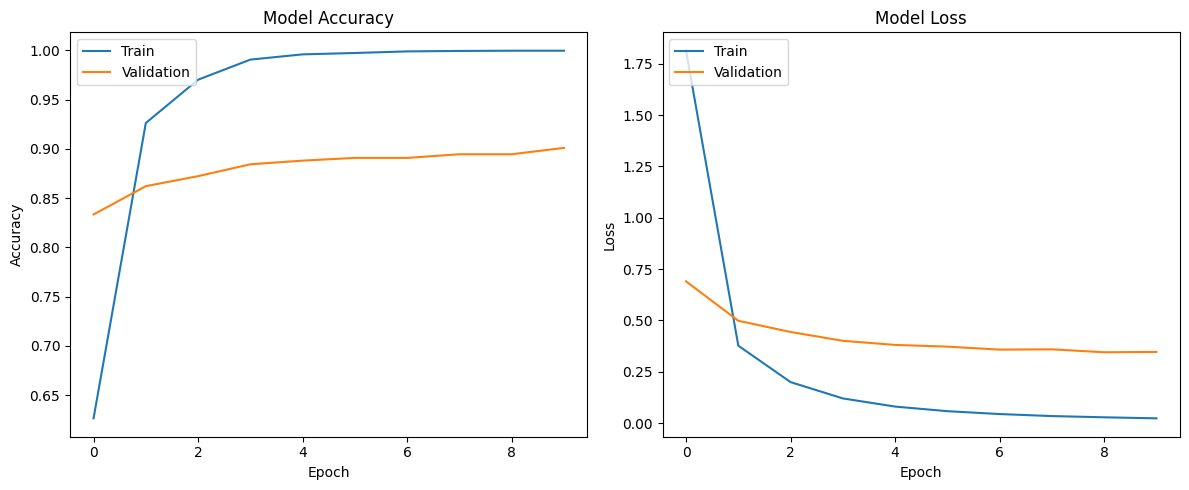

In [38]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

# for accuracy
ax1.plot(history.history['accuracy'])
ax1.plot(history.history['val_accuracy'])
ax1.set_title('Model Accuracy')
ax1.set_ylabel('Accuracy')
ax1.set_xlabel('Epoch')
ax1.legend(['Train', 'Validation'], loc='upper left')

# for loss
ax2.plot(history.history['loss'])
ax2.plot(history.history['val_loss'])
ax2.set_title('Model Loss')
ax2.set_ylabel('Loss')
ax2.set_xlabel('Epoch')
ax2.legend(['Train', 'Validation'], loc='upper left')
plt.tight_layout()
plt.show()

**Predicion Function**

In [39]:
def make_prediction(image_source):
    try:
        if image_source.startswith('http://') or image_source.startswith('https://'):
            print(f"Downloading image from URL: {image_source}")
            response = requests.get(image_source, stream=True)
            response.raise_for_status()
            img_content = BytesIO(response.content)
            img = Image.open(img_content)
            print("Image downloaded successfully.")
        else:
            print(f"Loading image from local path: {image_source}")
            if not os.path.exists(image_source):
                raise FileNotFoundError(f"Local file not found at: {image_source}")
            img = Image.open(image_source)

        # Preprocess the image
        img = img.resize((IMG_HEIGHT, IMG_WIDTH))
        img_array = tf.keras.utils.img_to_array(img)
        img_array = np.expand_dims(img_array, axis=0)
        img_array = normalization_layer(img_array)

        # Make the prediction
        predictions = model.predict(img_array)
        predicted_class_index = np.argmax(predictions[0])
        predicted_class_name = class_names[predicted_class_index]
        confidence = predictions[0][predicted_class_index]

        # Display Result
        print(f"\nPrediction Result:")
        print(f"  Predicted class: {predicted_class_name}")
        print(f"  Confidence: {confidence * 100:.2f}%")

        plt.imshow(img)
        plt.title(f'Prediction: {predicted_class_name}')
        plt.show()

    except Exception as e:
        print(f"An error occurred: {e}")

**Example Predictions**

--- Predicting from a local image ---
Loading image from local path: /content/animals_unzipped/animals/dog/5c641a8bde.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step

Prediction Result:
  Predicted class: dog
  Confidence: 98.86%


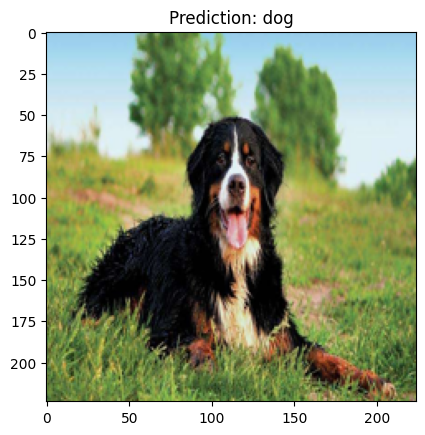


--- Predicting from a URL image ---
Image downloaded successfully.
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step

Prediction Result:
  Predicted class: lion
  Confidence: 98.80%


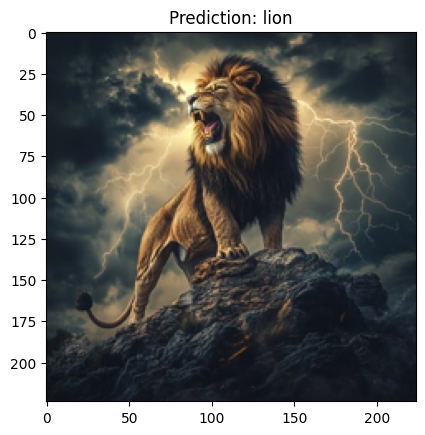

In [43]:
print("--- Predicting from a local image ---")
local_image_path = '/content/animals_unzipped/animals/dog/5c641a8bde.jpg'
make_prediction(local_image_path)

print("\n--- Predicting from a URL image ---")
url = "https://images.stockcake.com/public/5/0/e/50ec8b08-1a23-47e5-8ffa-d38c0e4200e8_large/majestic-lion-roaring-stockcake.jpg"
make_prediction(url)